# **Чистовик**

In [ ]:
import re
import pandas as pd
import os
from typing import Dict, List
import time

def get_files():
    """
    Функция поиска файлов Excel для дальнейшей обработки.
    Возвращает словарь с названием excel файла и списком листов для обработки.
    """
    current_dir = os.getcwd() # Возвращает /content
    files = os.listdir(current_dir) # Возвращает список с файлами и папками расположенных в директории
    dict_files = {}

    # Листы для удаления
    excluded_sheets = {
                      'dwh_etl_min_max_avg',
                      'External_min_max_avg',
                      'data_dparb_prod',
                      'dm_estaff',
                      'data_surv',
                      'data_webtutor',
                      'data_webtutor_hdp'
                      }

    for file in files:
        if re.fullmatch(r'\w+\.xlsx', file):
            try:
                with pd.ExcelFile(os.path.join(current_dir, file)) as xls:
                    sheets = [sheet for sheet in xls.sheet_names if sheet not in excluded_sheets]
                    if sheets:  # Добавляем только если есть листы для обработки
                        dict_files[file] = sheets
            except Exception as e:
                print(f"Ошибка обработки файла {file}: {e}")

    return dict_files



def concat_dataframe() -> pd.DataFrame:
    """
    Объединяет данные из всех файлов и листов в один DataFrame.
    """
    dict_file_sheets = get_files()
    dfs = []

    for file_name, sheets in dict_file_sheets.items():
        print(f"Обрабатывается файл: {file_name}, листы: {sheets}")
        for sheet_name in sheets:
            try:
                df = pd.read_excel(
                    os.path.join(os.getcwd(), file_name),
                    sheet_name=sheet_name
                )
                dfs.append(df)
            except Exception as e:
                print(f"Ошибка чтения листа {sheet_name} файла {file_name}: {e}")

    if not dfs:
        raise ValueError("Нет файлов для обработки")

    df_all = pd.concat(dfs, ignore_index=True)
    print(f"Всего строк: {len(df_all)}")
    return df_all

def process_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Обрабатка соединенного DataFrame.
    Возвращает результат стандартного времени загрузки и среднего времени отклонения от стандартного времени.
    """

    df['snapshot_end_dttm'] = pd.to_datetime(
        df['snapshot_end_dttm'],
        format='%Y-%m-%d %H:%M:%S',
        errors='coerce').dropna()

    if df.empty:
        raise ValueError("Нет данных после преобразования даты/времени")

    # Округление времени вверх до 30-й минуты и создание колонки только с временем
    # Для дальнейшей группировки
    df['hour_interval'] = df['snapshot_end_dttm'].dt.ceil('30min')
    df['time_only'] = df['hour_interval'].dt.time

    # Группировка и расчет количества интервалов
    df_interval_count = (df[['database_nm', 'table_nm', 'time_only']]
                         .groupby(['database_nm', 'table_nm', 'time_only'])
                         .size()
                         .reset_index(name='interval_count')
                         )
    #df_interval_count.to_excel('df_interval_count.xlsx')
    # Поиск самых частых интервалов (стандартное время)
    result = (df_interval_count
              .sort_values('interval_count', ascending=False)
              .drop_duplicates(subset=['database_nm', 'table_nm'])
              .reset_index(drop=True)
              )

    # Общее количество всех записей для каждой схема_таблица
    total_counts_df = (df
                       .groupby(['database_nm', 'table_nm'])
                       .size()
                       .reset_index(name='total_count')
                       )

    # Расчет отклонения от стандартного времени
    # ВПР основной таблицы, с таблицей где посчитано стандартное время
    df_with_std_time = pd.merge(df,
                                result[['database_nm', 'table_nm', 'time_only']],
                                on=['database_nm', 'table_nm'],
                                suffixes=('', '_std')
                                )

    # Время в минутах с 00:00 часов
    df_with_std_time['time_minutes'] = (df_with_std_time['snapshot_end_dttm'].dt.hour * 60
                                        +
                                        df_with_std_time['snapshot_end_dttm'].dt.minute
                                        )
    # Стандартное время в минутах с 00:00 часов
    df_with_std_time['std_time_minutes'] = (df_with_std_time['time_only_std']
                                            .apply(lambda x: x.hour * 60 + x.minute)
                                            )

    # Время отклонения в минутах от стандартного времени
    df_with_std_time['deviation_minutes'] = (df_with_std_time['time_minutes']
                                             -
                                             df_with_std_time['std_time_minutes']
                                             )

    #df_with_std_time.to_excel('df_with_std_time.xlsx')
    # Среднее отклонение в минутах от стандартного времени для схема_таблица
    avg_deviation = (
        df_with_std_time.groupby(['database_nm', 'table_nm'])
        ['deviation_minutes']
        .mean()
        .round(2)
        .reset_index(name='avg_deviation_minutes')
    )

    # ВПР всех результатов
    final = pd.merge(
        result,
        total_counts_df,
        on=['database_nm', 'table_nm']
    )

    final = pd.merge(
        final,
        avg_deviation,
        on=['database_nm', 'table_nm']
    )

    # Процент отклонений
    final['percent_deviation'] = (((final['total_count'] - final['interval_count']) / final['total_count']) * 100).round(2)

    final = final.rename(columns = {'time_only':'standart_time_load',
                        'interval_count':'standart_time_interval_count',
                        'total_count':'total_interval_count'})

    return final

print(f'Запуск скрипта')
start_time = time.time()
try:
    df = concat_dataframe()
    result_df = process_data(df)
    #result_df.to_excel('result_df.xlsx')
    print(f'Сохранено в файл  result_df.xlsx')
except Exception as e:
    print(f"Ошибка: {e}")

end_time = time.time()
all_time = end_time - start_time
print(f'Время выполнения: {all_time:.4f} секунд')

Запуск скрипта
Обрабатывается файл: data_webtutor_hdp.xlsx, листы: ['data_webtutor_hdp_det']
Обрабатывается файл: data_surv.xlsx, листы: ['data_surv_det']
Обрабатывается файл: data_dparb_prod.xlsx, листы: ['data_dparb_prod_det']
Обрабатывается файл: boss_kadr_qrs_LAB.xlsx, листы: ['dwh_etl_full', 'external_full']
Обрабатывается файл: data_webtutor.xlsx, листы: ['data_webtutor_det']
Обрабатывается файл: data_estaff.xlsx, листы: ['dm_estaff_det']
Всего строк: 34904
Сохранено в файл  result_df.xlsx
Время выполнения: 7.0525 секунд


# **V2**

Добавить проверку по дате

Заменить report на result

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import ipywidgets as widgets
from IPython.display import display, HTML
import os
from datetime import datetime

import re
from typing import Dict, List
import time

def get_files():
    """
    Функция поиска файлов Excel для дальнейшей обработки.
    Возвращает словарь с названием excel файла и списком листов для обработки.
    """
    current_dir = os.getcwd() # Возвращает /content
    files = os.listdir(current_dir) # Возвращает список с файлами и папками расположенных в директории
    dict_files = {}

    # Листы для удаления
    excluded_sheets = {
                      'dwh_etl_min_max_avg',
                      'External_min_max_avg',
                      'data_dparb_prod',
                      'dm_estaff',
                      'data_surv',
                      'data_webtutor',
                      'data_webtutor_hdp'
                      }

    for file in files:
        if re.fullmatch(r'\w+\.xlsx', file):
            try:
                with pd.ExcelFile(os.path.join(current_dir, file)) as xls:
                    sheets = [sheet for sheet in xls.sheet_names if sheet not in excluded_sheets]
                    if sheets:  # Добавляем только если есть листы для обработки
                        dict_files[file] = sheets
            except Exception as e:
                print(f"Ошибка обработки файла {file}: {e}")

    return dict_files



def concat_dataframe() -> pd.DataFrame:
    """
    Объединяет данные из всех файлов и листов в один DataFrame.
    """
    dict_file_sheets = get_files()
    dfs = []

    for file_name, sheets in dict_file_sheets.items():
        print(f"Обрабатывается файл: {file_name}, листы: {sheets}")
        for sheet_name in sheets:
            try:
                df = pd.read_excel(
                    os.path.join(os.getcwd(), file_name),
                    sheet_name=sheet_name
                )
                dfs.append(df)
            except Exception as e:
                print(f"Ошибка чтения листа {sheet_name} файла {file_name}: {e}")

    if not dfs:
        raise ValueError("Нет файлов для обработки")

    df_all = pd.concat(dfs, ignore_index=True)
    df_all = df_all[(df_all['snapshot_end_dttm'].isna() == False)]
    print(f"Всего строк: {len(df_all)}")
    return df_all


def minutes_to_time(minutes):
  return f"{int(minutes//60):02d}:{int(minutes%60):02d}"


def process_data(df):

  df['snapshot_end_dttm'] = pd.to_datetime(
          df['snapshot_end_dttm'],
          format='%Y-%m-%d %H:%M:%S',
          errors='coerce').dropna()

  df['minutes'] = df['snapshot_end_dttm'].dt.hour * 60 + df['snapshot_end_dttm'].dt.minute

  if df.empty:
    raise ValueError("Нет данных после преобразования даты/времени")

  df_stats = df.groupby(['database_nm', 'table_nm']).agg(
                    interval_count=('minutes', 'count'),
                    std_time =('minutes', lambda x: x.quantile(0.9)),
                    min_time = ('minutes', lambda x: x.min()),
                    max_time = ('minutes', lambda x: x.max()),
                    mean_time=('minutes', 'mean'),
                    std_time_minutes = ('minutes', lambda x: x.quantile(0.9))).reset_index()


  df_stats['deviation_pct'] = ((df_stats['mean_time'] - df_stats['std_time']) / df_stats['std_time'] * 100).round(2)




  for col in ['std_time', 'min_time', 'max_time', 'mean_time']:
      df_stats[col] = df_stats[col].apply(minutes_to_time)
  return df_stats



print(f'Запуск скрипта')
start_time = time.time()
try:
    df = concat_dataframe()
    result_df = process_data(df)
    #result_df.to_excel('result_df.xlsx')
    print(f'Сохранено в файл  result_df.xlsx')
except Exception as e:
    print(f"Ошибка: {e}")

end_time = time.time()
all_time = end_time - start_time
print(f'Время выполнения: {all_time:.4f} секунд')


# Виджеты
schema_dropdown = widgets.Dropdown( # Выпадающий список всех схем (database_nm)
    options=sorted(df['database_nm'].unique()),
    description='Схема:',
    disabled=False
)

table_dropdown = widgets.Dropdown( # Пустой выпадающий список для таблиц, которые грузятся в зависимости от выбранной схемы
    description='Таблица:',
    disabled=False
)

# Кнопки
update_button = widgets.Button(description="Обновить графики", button_style='info')
export_button = widgets.Button(description="Скачать Excel", button_style='success')

# Выходные области
graph_output = widgets.Output()
result_output = widgets.Output()

# Обновление списка таблиц
def update_table_dropdown(*args):
    selected_schema = schema_dropdown.value
    tables = sorted(df[df['database_nm'] == selected_schema]['table_nm'].unique())
    table_dropdown.options = tables
    if tables:
        table_dropdown.value = tables[0]

schema_dropdown.observe(update_table_dropdown, 'value')
update_table_dropdown()

# Графики
def plot_charts(schema, table):
    with graph_output: # Область, которую задал выше
        graph_output.clear_output(wait=True) # Удалить старую инфу

        filtered_df = df[(df['database_nm'] == schema) & (df['table_nm'] == table)] # Передал общий df, который конкатенатил
        if filtered_df.empty:
            print("Для выбранной схемы и таблицы нет данных")
            #return

        stats = result_df[(result_df['database_nm'] == schema) & (result_df['table_nm'] == table)].iloc[0] # Для 90-го перцентиля, данные беру из result_df
        percentile_90 = stats['std_time_minutes']

        # Сделать сетку. 3 строки, на одной строке 1 график
        fig,(ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

        # График 1: Точечный
        ax1.scatter(filtered_df['minutes'], np.ones(len(filtered_df)), alpha=0.2, s=100) # По y сделал просто массив единиц np.ones(len(filtered_df))
        ax1.axvline(x=percentile_90, color='red', linestyle='--', linewidth=2, label=f'Стандартное время {minutes_to_time(percentile_90)}')
        ax1.set_title(f'Точечный график: {schema}.{table}')
        ax1.legend()
        #ax1.set_yticks([])  # Убрать ось Y

        # График 2: Гистограмма
        ax2.hist(filtered_df['minutes'], bins=48, range=(0, 1440), edgecolor='white') # 1440 количество минут в сутках, 48 корзин по 30 минут
        ax2.axvline(x=percentile_90, color='red', linestyle='--', linewidth=2, label=f'Стандартное время {minutes_to_time(percentile_90)}')
        ax2.set_title(f'{schema}.{table}')
        ax2.set_ylabel('Количество загрузок')
        ax2.legend()

        # График 3: Плотность
        density = gaussian_kde(filtered_df['minutes'])
        x = np.linspace(0, 1440, 1440) # Старт, стоп, сколько точек
        ax3.plot(x, density(x), 'b-', linewidth=2)
        ax3.axvline(x=percentile_90, color='red', linestyle='--', linewidth=2, label=f'Стандартное время {minutes_to_time(percentile_90)}')
        ax3.set_title(f'{schema}.{table}')
        ax3.set_ylabel('Плотность')
        ax3.legend()

        # Общие настройки
        for ax in [ax1, ax2, ax3]:
            ax.set_xlim(0, 1440)
            ax.set_xticks(range(0, 1441, 120)) # Шаг оси по x
            ax.set_xticklabels([f"{h//60:02d}:00" for h in range(0, 1441, 120)], rotation=45)
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Вывод статистики
        display(HTML(f"""
        <h3>Статистика для {schema}.{table}</h3>
        <ul>
            <li><b>Всего загрузок:</b> {stats['interval_count']}</li>
            <li><b>Стандартное время загрузки (90% перцентиль):</b> {stats['std_time']}</li>
            <li><b>Минимальное время загрузки:</b> {stats['min_time']}</li>
            <li><b>Максимальное время загрузки:</b> {stats['max_time']}</li>
            <li><b>Среднее время загрузки:</b> {stats['mean_time']}</li>
            <li><b>Процент отклонения от стандартного времени:</b> {stats['deviation_pct']}</li>
        </ul>
        """))

# Обработчики кнопок
def on_update_click(b):
    plot_charts(schema_dropdown.value, table_dropdown.value)

def on_export_click(b):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"result_{timestamp}.xlsx"

    export_df = result_df.drop(columns=['std_time_minutes'])
    export_df.to_excel(filename, index=False)

    with result_output:
        result_output.clear_output()
        print(f"Cохранено в {filename}")
        display(export_df)

update_button.on_click(on_update_click)
export_button.on_click(on_export_click)

# Отобразить интерфейс
display(widgets.VBox([
    widgets.HBox([schema_dropdown, table_dropdown]),
    widgets.HBox([update_button, export_button]),
    graph_output,
    result_output
]))

# Автоматическая загрузка первого графика
plot_charts(schema_dropdown.value, table_dropdown.value)

Запуск скрипта
Обрабатывается файл: data_webtutor.xlsx, листы: ['data_webtutor_det']
Обрабатывается файл: data_surv.xlsx, листы: ['data_surv_det']
Обрабатывается файл: data_estaff.xlsx, листы: ['dm_estaff_det']
Обрабатывается файл: data_dparb_prod.xlsx, листы: ['data_dparb_prod_det']
Обрабатывается файл: boss_kadr_qrs_LAB.xlsx, листы: ['dwh_etl_full', 'external_full']
Обрабатывается файл: data_webtutor_hdp.xlsx, листы: ['data_webtutor_hdp_det']
Всего строк: 34888
Сохранено в файл  result_df.xlsx
Время выполнения: 10.6873 секунд


# **Тесты виджетов**

In [ ]:
from ipywidgets import widgets

# Выпадающий список
dropdown = widgets.Dropdown(
    options=['Python', 'JavaScript', 'R', 'Julia'], # Список или словарь вариантов
    value='Python',  # Значение по умолчанию
    description='Язык:',  # Подпись перед списком (например, "Язык:")
    disabled=False,  # True/False — блокировка выбора. Если True, список будет заблокирован
)

#display(dropdown)  # Отобразить в Jupyter

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact

def plot_lang(lang):
    x = np.linspace(0, 10, 100)
    if lang == 'Python':
        y = np.sin(x)
    elif lang == 'JavaScript':
        y = np.cos(x)
    elif lang == 'Julia':
        y = x**2
    else:
        y = x
    plt.plot(x, y)
    plt.title(f"График для {lang}")

interact(plot_lang, lang=dropdown)  # Динамическое обновление графика

interactive(children=(Dropdown(description='Язык:', options=('Python', 'JavaScript', 'R', 'Julia'), value='Pyt…

<function __main__.plot_lang(lang)>

In [ ]:
from IPython.display import display

# Функция для реакции на выбор
def on_dropdown_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print(f"Теперь выбран: {change['new']}")

dropdown = widgets.Dropdown(
    options=['Яблоки', 'Апельсины', 'Бананы'],
    description='Фрукты:'
)

dropdown.observe(on_dropdown_change)
display(dropdown)

Dropdown(description='Фрукты:', options=('Яблоки', 'Апельсины', 'Бананы'), value='Яблоки')

Теперь выбран: Бананы


In [ ]:
# Получить выбранное значение
# Вариант 1: Через атрибут .value
selected_value = dropdown.value
print(f"Выбрано: {selected_value}")

Выбрано: Python


In [ ]:
# Получить выбранное значение
# Вариант 2: Через observer (автоматически при изменении)
def on_change(change):
    print(f"Новое значение: {change['new']}")

dropdown.observe(on_change, names='value')

In [ ]:
dropdown.options = ['Go', 'Ruby', 'Swift']

Новое значение: Go


In [ ]:
from ipywidgets import widgets, Layout

output = widgets.Output(layout={'border': '1px solid black'})

with output:
    print("Привет, мир!")
    print(2 + 2)

display(output)

Output(layout=Layout(border='1px solid black'))

In [ ]:
from ipywidgets import interact

def square(x):
    return x ** 2

interact(square, x=widgets.IntSlider(min=0, max=10, step=1, value=2))


interactive(children=(IntSlider(value=2, description='x', max=10), Output()), _dom_classes=('widget-interact',…

<function __main__.square(x)>

# **Тест**

In [ ]:
У менч есть таблица с схема, название таблицы, время окончания загрузки
Мне надо для каждой схема, название таблицы опрелять временной интервал
то есть беру временную шкалу с 00-00 до 23-59 и откладываю точки в какое время загрузка
после чего определяю, там где 90% точек (например одна загрузка в 6-00, вторая в 7-00, третья в 8-00, четвертая в 16-00. 90%
в интервале от 6 до 8 часов, значит стандартное время загрузки 8 -00)
беру самое крайнее время, это и будет стандартное время загрузки


мне надо вот все это
только на графики добавить черту
которая отсекает
тоесть у нас есть например 10 точек (времен загрузок)
1 точка в 07-00
2 точка в 07-30
....
9 точка в 12-00
10 точка в 16-00

черту ставим на метке 12-00, так как до 12-00 лежит 90% точек со временем


Перцентиль — это значение, ниже которого находится определённый процент данных. Например, 90-й перцентиль — это значение, ниже которого находится 90% всех данных.

Сделать интерактивный дашборд с выпадающем списком для схема - таблица

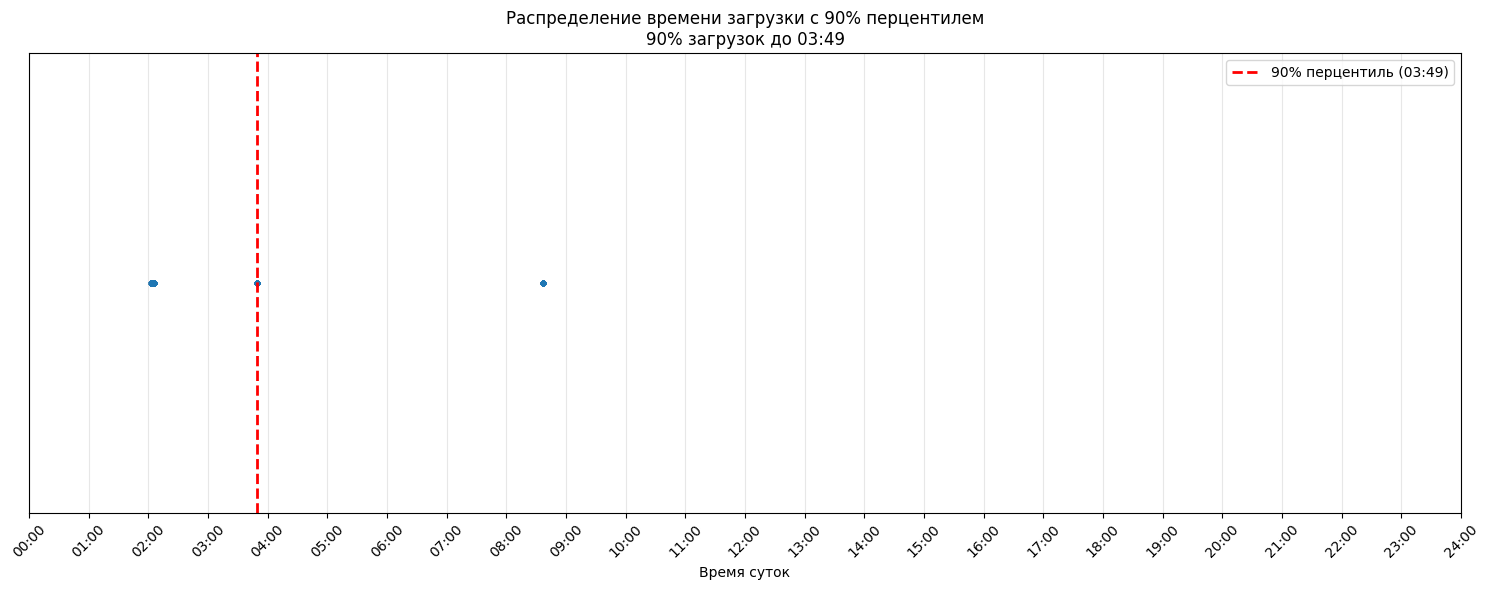

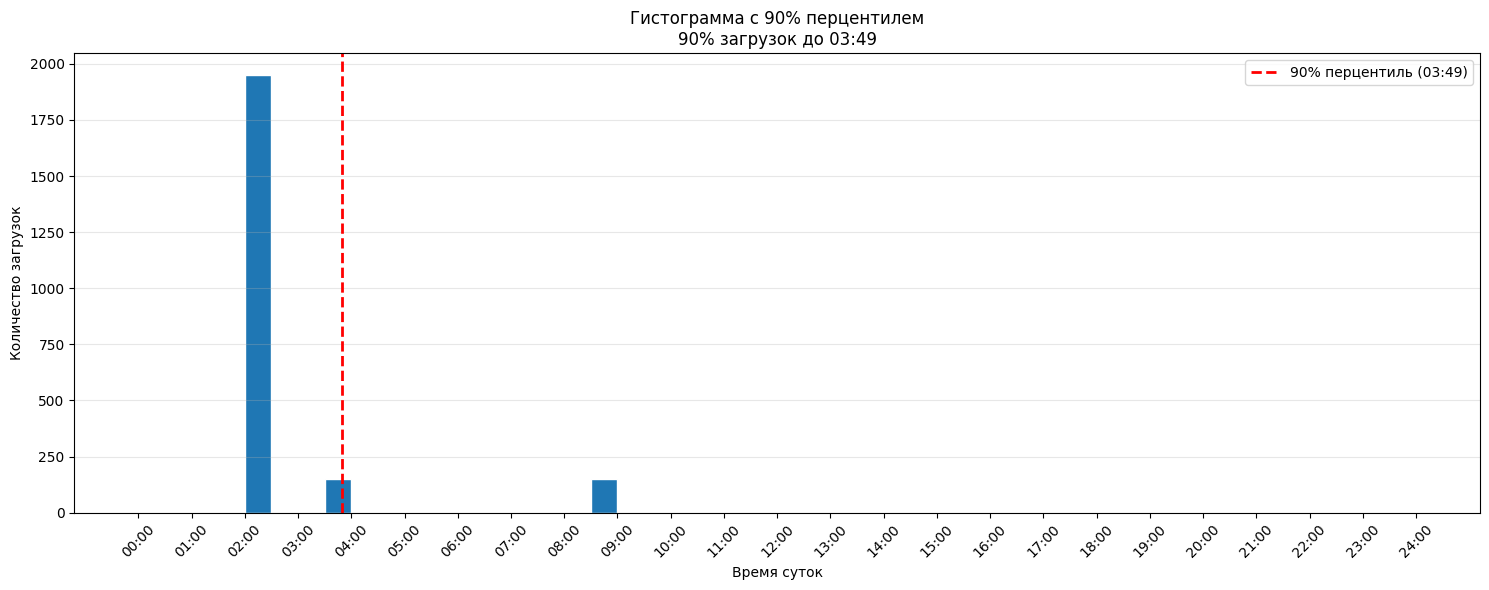

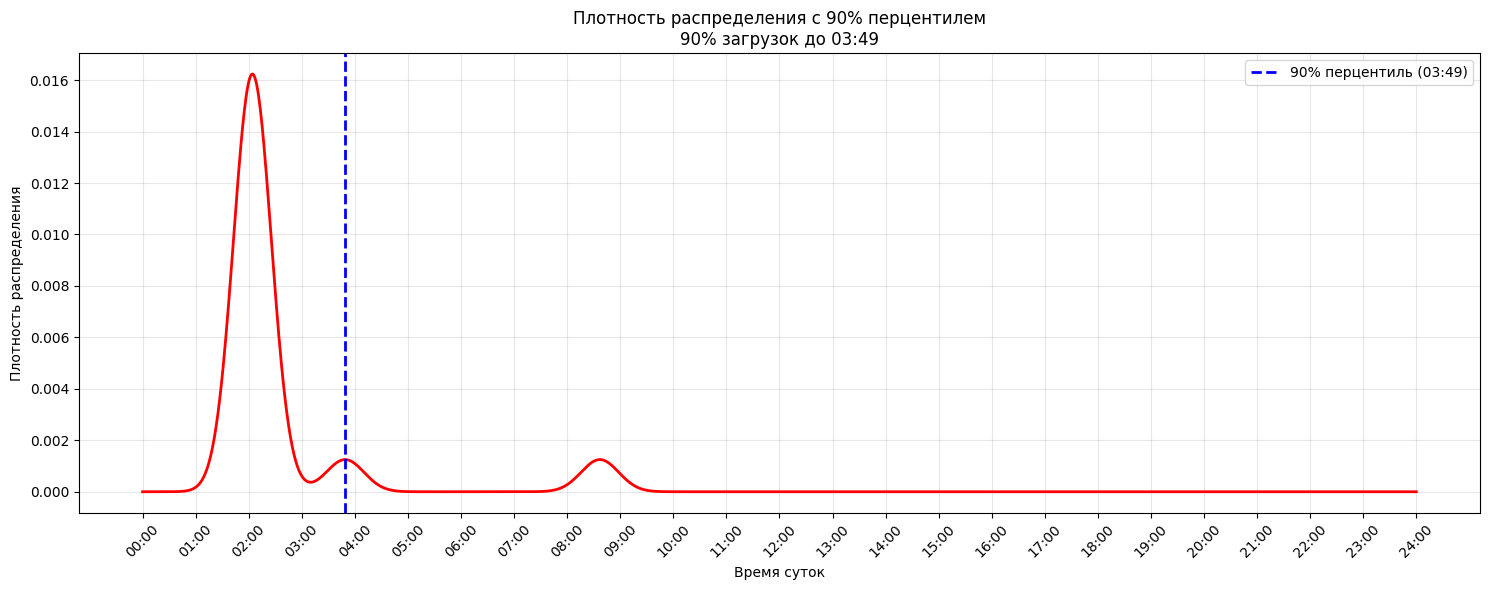

90% загрузок происходят до 03:49


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

# Создаем тестовые данные
data = {
    'snapshot_end_dttm': [
        '01.05.2024 2:04:28', '02.05.2024 2:03:49', '03.05.2024 2:04:08',
        '04.05.2024 2:04:40', '05.05.2024 2:04:16', '06.05.2024 2:05:41',
        '07.05.2024 2:06:15', '08.05.2024 2:05:28', '09.05.2024 8:37:20',
        '10.05.2024 2:03:34', '11.05.2024 2:04:55', '12.05.2024 3:49:17',
        '13.05.2024 2:04:36', '14.05.2024 2:04:00', '15.05.2024 2:04:40'
    ] * 150  # Умножаем для имитации 2000+ точек
}

df = pd.DataFrame(data)
df['snapshot_end_dttm'] = pd.to_datetime(df['snapshot_end_dttm'], format='%d.%m.%Y %H:%M:%S')
df['minutes'] = df['snapshot_end_dttm'].dt.hour * 60 + df['snapshot_end_dttm'].dt.minute

# Функция для нахождения 90-го перцентиля
def find_90_percentile(minutes):
    sorted_min = np.sort(minutes)
    n = len(sorted_min)
    idx = int(0.9 * n) - 1  # Индекс 90-го перцентиля
    return sorted_min[idx]

# Находим 90-й перцентиль
percentile_90 = find_90_percentile(df['minutes'])

# Преобразуем минуты обратно в время для подписи
def minutes_to_time(minutes):
    return f"{int(minutes//60):02d}:{int(minutes%60):02d}"

# Способ 1: Точечный график с 90-м перцентилем
plt.figure(figsize=(15, 6))
y_values = np.ones(len(df)) * 0.5
plt.scatter(df['minutes'], y_values, alpha=0.1, s=10)

# Добавляем линию 90-го перцентиля
plt.axvline(x=percentile_90, color='red', linestyle='--', linewidth=2,
            label=f'90% перцентиль ({minutes_to_time(percentile_90)})')

plt.xlim(0, 1440)
plt.ylim(0, 1)
hours = range(0, 1441, 60)
plt.xticks(hours, [f"{h//60:02d}:00" for h in hours], rotation=45)
plt.xlabel('Время суток')
plt.yticks([])
plt.title(f'Распределение времени загрузки с 90% перцентилем\n90% загрузок до {minutes_to_time(percentile_90)}')
plt.grid(True, axis='x', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Способ 2: Гистограмма с 90-м перцентилем
plt.figure(figsize=(15, 6))
plt.hist(df['minutes'], bins=48, range=(0, 1440), edgecolor='white')

# Добавляем линию 90-го перцентиля
plt.axvline(x=percentile_90, color='red', linestyle='--', linewidth=2,
            label=f'90% перцентиль ({minutes_to_time(percentile_90)})')

plt.xticks(hours, [f"{h//60:02d}:00" for h in hours], rotation=45)
plt.xlabel('Время суток')
plt.ylabel('Количество загрузок')
plt.title(f'Гистограмма с 90% перцентилем\n90% загрузок до {minutes_to_time(percentile_90)}')
plt.grid(True, axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Способ 3: Плотность распределения с 90-м перцентилем
plt.figure(figsize=(15, 6))
density = gaussian_kde(df['minutes'])
x = np.linspace(0, 1440, 1440)
plt.plot(x, density(x), 'r-', linewidth=2)

# Добавляем линию 90-го перцентиля
plt.axvline(x=percentile_90, color='blue', linestyle='--', linewidth=2,
            label=f'90% перцентиль ({minutes_to_time(percentile_90)})')

plt.xticks(hours, [f"{h//60:02d}:00" for h in hours], rotation=45)
plt.xlabel('Время суток')
plt.ylabel('Плотность распределения')
plt.title(f'Плотность распределения с 90% перцентилем\n90% загрузок до {minutes_to_time(percentile_90)}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Выводим информацию о 90% перцентиле
print(f"90% загрузок происходят до {minutes_to_time(percentile_90)}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import ipywidgets as widgets
from IPython.display import display

# Создаем тестовые данные
np.random.seed(42)
data = {
    'database_nm': np.random.choice(['schema1', 'schema2', 'schema3'], size=2000),
    'table_nm': np.random.choice(['tableA', 'tableB', 'tableC', 'tableD'], size=2000),
    'snapshot_end_dttm': pd.to_datetime('2024-05-01') + pd.to_timedelta(np.random.normal(12, 4, 2000)*60, unit='m')
}
df = pd.DataFrame(data)
df['minutes'] = df['snapshot_end_dttm'].dt.hour * 60 + df['snapshot_end_dttm'].dt.minute

# Функция для нахождения 90-го перцентиля
def find_90_percentile(minutes):
    sorted_min = np.sort(minutes)
    n = len(sorted_min)
    idx = int(0.9 * n) - 1
    return sorted_min[idx]

# Функция преобразования минут в время
def minutes_to_time(minutes):
    return f"{int(minutes//60):02d}:{int(minutes%60):02d}"

# Создаем виджеты для фильтрации
schema_dropdown = widgets.Dropdown(
    options=sorted(df['database_nm'].unique()),
    description='Схема:',
    disabled=False
)

table_dropdown = widgets.Dropdown(
    description='Таблица:',
    disabled=False
)

# Обновляем список таблиц при изменении схемы
def update_table_dropdown(*args):
    selected_schema = schema_dropdown.value
    tables = sorted(df[df['database_nm'] == selected_schema]['table_nm'].unique())
    table_dropdown.options = tables
    if tables:
        table_dropdown.value = tables[0]

schema_dropdown.observe(update_table_dropdown, 'value')
update_table_dropdown()  # Инициализация

# Создаем кнопку для обновления графиков
update_button = widgets.Button(description="Обновить графики")

# Выходная область для графиков
output = widgets.Output()

# Функция для создания графиков
def plot_charts(schema, table):
    with output:
        output.clear_output(wait=True)

        # Фильтруем данные
        filtered_df = df[(df['database_nm'] == schema) & (df['table_nm'] == table)]
        if filtered_df.empty:
            print("Нет данных для выбранной схемы и таблицы")
            return

        # Вычисляем 90% перцентиль
        percentile_90 = find_90_percentile(filtered_df['minutes'])

        # Создаем фигуру с тремя subplots
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18))

        # График 1: Точечный график
        y_values = np.ones(len(filtered_df)) * 0.5
        ax1.scatter(filtered_df['minutes'], y_values, alpha=0.2, s=50)
        ax1.axvline(x=percentile_90, color='red', linestyle='--', linewidth=2)
        ax1.set_xlim(0, 1440)
        ax1.set_ylim(0, 1)
        ax1.set_xticks(range(0, 1441, 120))
        ax1.set_xticklabels([f"{h//60:02d}:00" for h in range(0, 1441, 120)], rotation=45)
        ax1.set_yticks([])
        ax1.set_title(f'Точечный график загрузок\n{schema}.{table}\n90% загрузок до {minutes_to_time(percentile_90)}')
        ax1.grid(True, axis='x', alpha=0.3)

        # График 2: Гистограмма
        ax2.hist(filtered_df['minutes'], bins=48, range=(0, 1440), edgecolor='white')
        ax2.axvline(x=percentile_90, color='red', linestyle='--', linewidth=2)
        ax2.set_xticks(range(0, 1441, 120))
        ax2.set_xticklabels([f"{h//60:02d}:00" for h in range(0, 1441, 120)], rotation=45)
        ax2.set_title('Гистограмма распределения времени загрузок')
        ax2.set_ylabel('Количество загрузок')
        ax2.grid(True, axis='y', alpha=0.3)

        # График 3: Плотность распределения
        density = gaussian_kde(filtered_df['minutes'])
        x = np.linspace(0, 1440, 1440)
        ax3.plot(x, density(x), 'b-', linewidth=2)
        ax3.axvline(x=percentile_90, color='red', linestyle='--', linewidth=2)
        ax3.set_xticks(range(0, 1441, 120))
        ax3.set_xticklabels([f"{h//60:02d}:00" for h in range(0, 1441, 120)], rotation=45)
        ax3.set_title('Плотность распределения времени загрузок')
        ax3.set_ylabel('Плотность')
        ax3.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Выводим статистику
        print(f"Всего загрузок: {len(filtered_df)}")
        print(f"90% загрузок происходят до: {minutes_to_time(percentile_90)}")
        print(f"Минимальное время загрузки: {minutes_to_time(filtered_df['minutes'].min())}")
        print(f"Максимальное время загрузки: {minutes_to_time(filtered_df['minutes'].max())}")
        print(f"Среднее время загрузки: {minutes_to_time(filtered_df['minutes'].mean())}")

# Обработчик нажатия кнопки
def on_button_click(b):
    plot_charts(schema_dropdown.value, table_dropdown.value)

update_button.on_click(on_button_click)

# Отображаем все виджеты
display(widgets.VBox([
    widgets.HBox([schema_dropdown, table_dropdown]),
    update_button,
    output
]))

# Автоматически загружаем первый график
plot_charts(schema_dropdown.value, table_dropdown.value)

In [ ]:
df.head(2)

,database_nm,table_nm,snapshot_end_dttm,minutes
0,schema3,tableB,2024-05-01 14:45:05.231911494,885
1,schema1,tableD,2024-05-01 13:40:43.183525410,820


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import ipywidgets as widgets
from IPython.display import display, HTML
import os
from datetime import datetime

# Создаем тестовые данные
np.random.seed(42)
data = {
    'database_nm': np.random.choice(['schema1', 'schema2', 'schema3'], size=2000),
    'table_nm': np.random.choice(['tableA', 'tableB', 'tableC', 'tableD'], size=2000),
    'snapshot_end_dttm': pd.to_datetime('2024-05-01') + pd.to_timedelta(np.random.normal(12, 4, 2000)*60, unit='m')
}
df = pd.DataFrame(data)
df['minutes'] = df['snapshot_end_dttm'].dt.hour * 60 + df['snapshot_end_dttm'].dt.minute

# Функции для расчетов
def find_90_percentile(minutes):
    sorted_min = np.sort(minutes)
    n = len(sorted_min)
    idx = int(0.9 * n) - 1
    return sorted_min[idx]

def minutes_to_time(minutes):
    return f"{int(minutes//60):02d}:{int(minutes%60):02d}"

def calculate_stats(group):
    minutes = group['minutes'].values
    if len(minutes) == 0:
        return pd.Series()

    std_time = find_90_percentile(minutes)
    avg_time = np.mean(minutes)
    deviation = np.mean(np.abs(minutes - std_time))

    return pd.Series({
        'Всего загрузок': len(minutes),
        'Стандартное время загрузки': minutes_to_time(std_time),
        'Минимальное время загрузки': minutes_to_time(min(minutes)),
        'Максимальное время загрузки': minutes_to_time(max(minutes)),
        'Среднее время загрузки': minutes_to_time(avg_time),
        'Процент отклонения от стандартного времени': f"{(deviation / (24*60)) * 100:.2f}%",
        'std_time_minutes': std_time  # Скрытое поле для расчетов
    })

# Создаем отчетную таблицу
report_df = df.groupby(['database_nm', 'table_nm']).apply(calculate_stats).reset_index()

# Удаляем строки с пустыми данными
report_df = report_df.dropna()

# Создаем виджеты
schema_dropdown = widgets.Dropdown(
    options=sorted(df['database_nm'].unique()),
    description='Схема:',
    disabled=False
)

table_dropdown = widgets.Dropdown(
    description='Таблица:',
    disabled=False
)

# Кнопки
update_button = widgets.Button(description="Обновить графики", button_style='info')
export_button = widgets.Button(description="Экспорт в Excel", button_style='success')

# Выходные области
graph_output = widgets.Output()
report_output = widgets.Output()

# Обновляем список таблиц
def update_table_dropdown(*args):
    selected_schema = schema_dropdown.value
    tables = sorted(df[df['database_nm'] == selected_schema]['table_nm'].unique())
    table_dropdown.options = tables
    if tables:
        table_dropdown.value = tables[0]

schema_dropdown.observe(update_table_dropdown, 'value')
update_table_dropdown()

# Функция для создания графиков
def plot_charts(schema, table):
    with graph_output:
        graph_output.clear_output(wait=True)

        filtered_df = df[(df['database_nm'] == schema) & (df['table_nm'] == table)]
        if filtered_df.empty:
            print("Нет данных для выбранной схемы и таблицы")
            return

        stats = report_df[(report_df['database_nm'] == schema) & (report_df['table_nm'] == table)].iloc[0]
        percentile_90 = stats['std_time_minutes']

        # Создаем фигуру
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18))

        # График 1: Точечный
        ax1.scatter(filtered_df['minutes'], np.ones(len(filtered_df))*0.5, alpha=0.2, s=50)
        ax1.axvline(x=percentile_90, color='red', linestyle='--', linewidth=2)
        ax1.set_title(f'Точечный график: {schema}.{table}')

        # График 2: Гистограмма
        ax2.hist(filtered_df['minutes'], bins=48, range=(0, 1440), edgecolor='white')
        ax2.axvline(x=percentile_90, color='red', linestyle='--', linewidth=2)
        ax2.set_ylabel('Количество загрузок')

        # График 3: Плотность
        density = gaussian_kde(filtered_df['minutes'])
        x = np.linspace(0, 1440, 1440)
        ax3.plot(x, density(x), 'b-', linewidth=2)
        ax3.axvline(x=percentile_90, color='red', linestyle='--', linewidth=2)
        ax3.set_ylabel('Плотность')

        # Общие настройки
        for ax in [ax1, ax2, ax3]:
            ax.set_xlim(0, 1440)
            ax.set_xticks(range(0, 1441, 120))
            ax.set_xticklabels([f"{h//60:02d}:00" for h in range(0, 1441, 120)], rotation=45)
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Выводим статистику
        display(HTML(f"""
        <h3>Статистика для {schema}.{table}</h3>
        <ul>
            <li><b>Всего загрузок:</b> {stats['Всего загрузок']}</li>
            <li><b>Стандартное время загрузки (90% перцентиль):</b> {stats['Стандартное время загрузки']}</li>
            <li><b>Минимальное время загрузки:</b> {stats['Минимальное время загрузки']}</li>
            <li><b>Максимальное время загрузки:</b> {stats['Максимальное время загрузки']}</li>
            <li><b>Среднее время загрузки:</b> {stats['Среднее время загрузки']}</li>
            <li><b>Процент отклонения от стандартного времени:</b> {stats['Процент отклонения от стандартного времени']}</li>
        </ul>
        """))

# Обработчики кнопок
def on_update_click(b):
    plot_charts(schema_dropdown.value, table_dropdown.value)

def on_export_click(b):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"report_{timestamp}.xlsx"

    # Экспортируем без скрытого столбца
    export_df = report_df.drop(columns=['std_time_minutes'])
    export_df.to_excel(filename, index=False)

    with report_output:
        report_output.clear_output()
        print(f"Отчет успешно сохранен как {filename}")
        display(export_df)

update_button.on_click(on_update_click)
export_button.on_click(on_export_click)

# Отображаем интерфейс
display(widgets.VBox([
    widgets.HBox([schema_dropdown, table_dropdown]),
    widgets.HBox([update_button, export_button]),
    graph_output,
    report_output
]))

# Автоматически загружаем первый график
plot_charts(schema_dropdown.value, table_dropdown.value)

<ipython-input-182-0c1e7b2b0d81>:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  report_df = df.groupby(['database_nm', 'table_nm']).apply(calculate_stats).reset_index()


# **Графики**


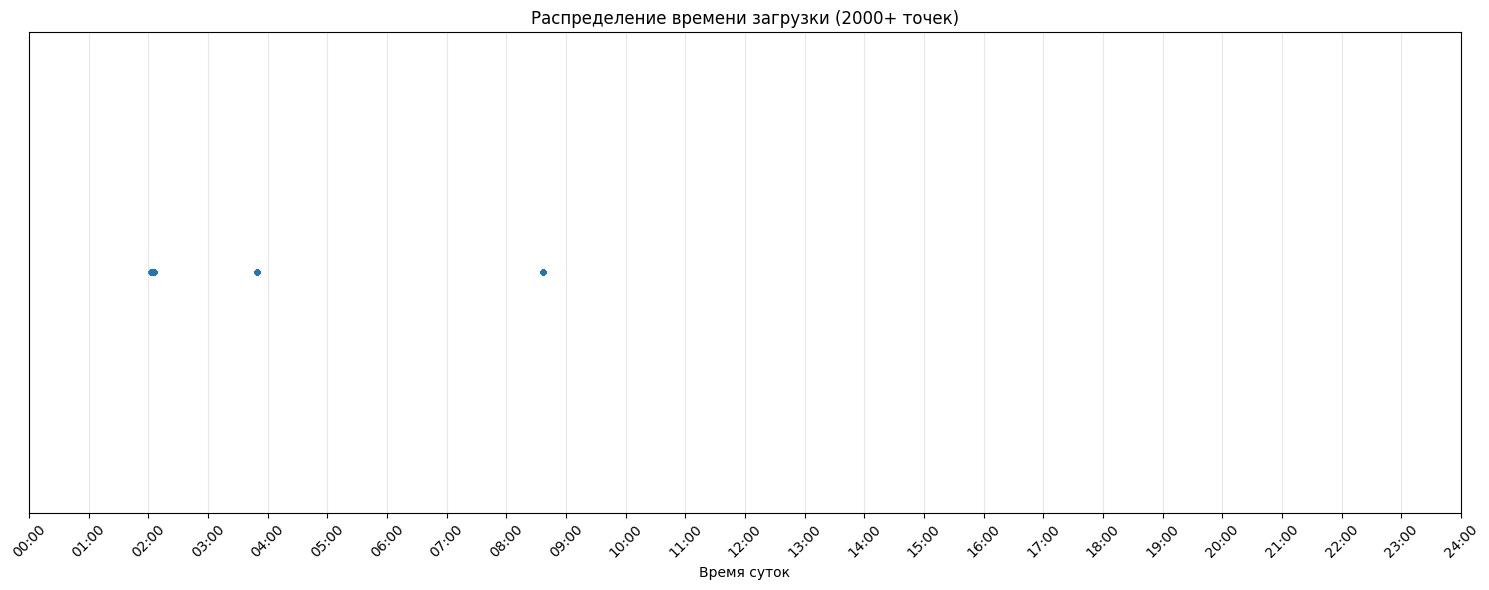

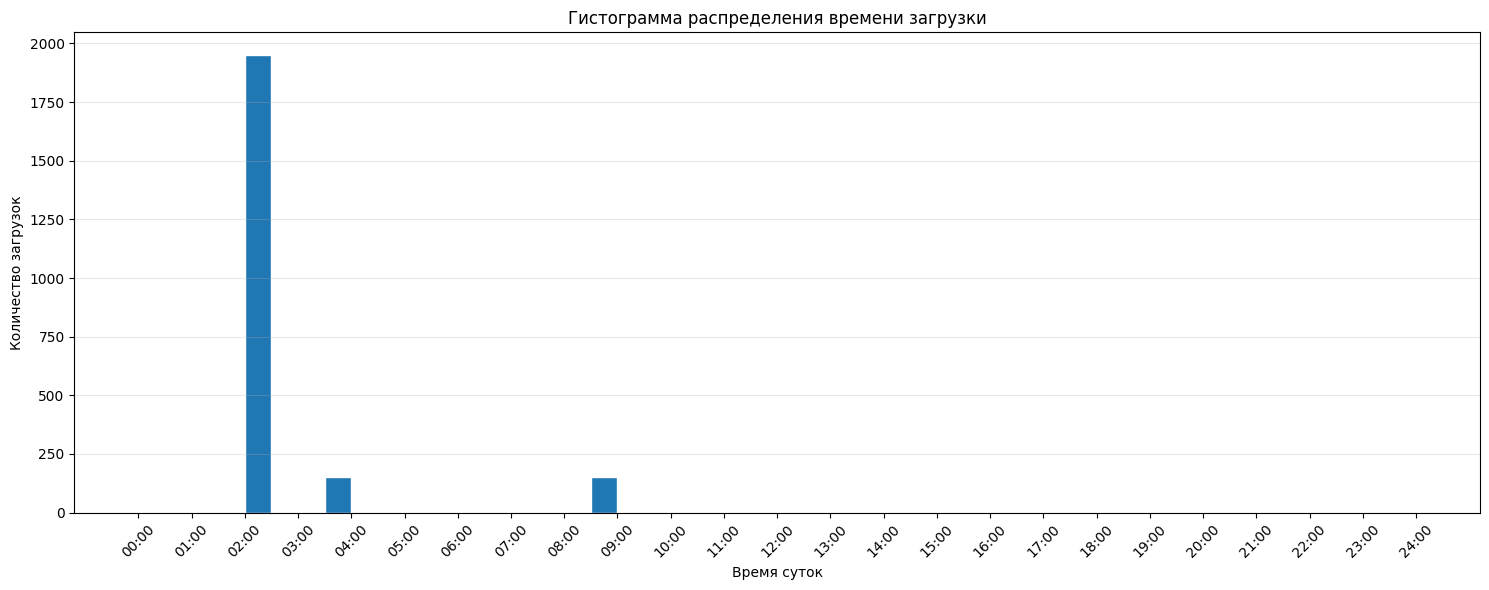

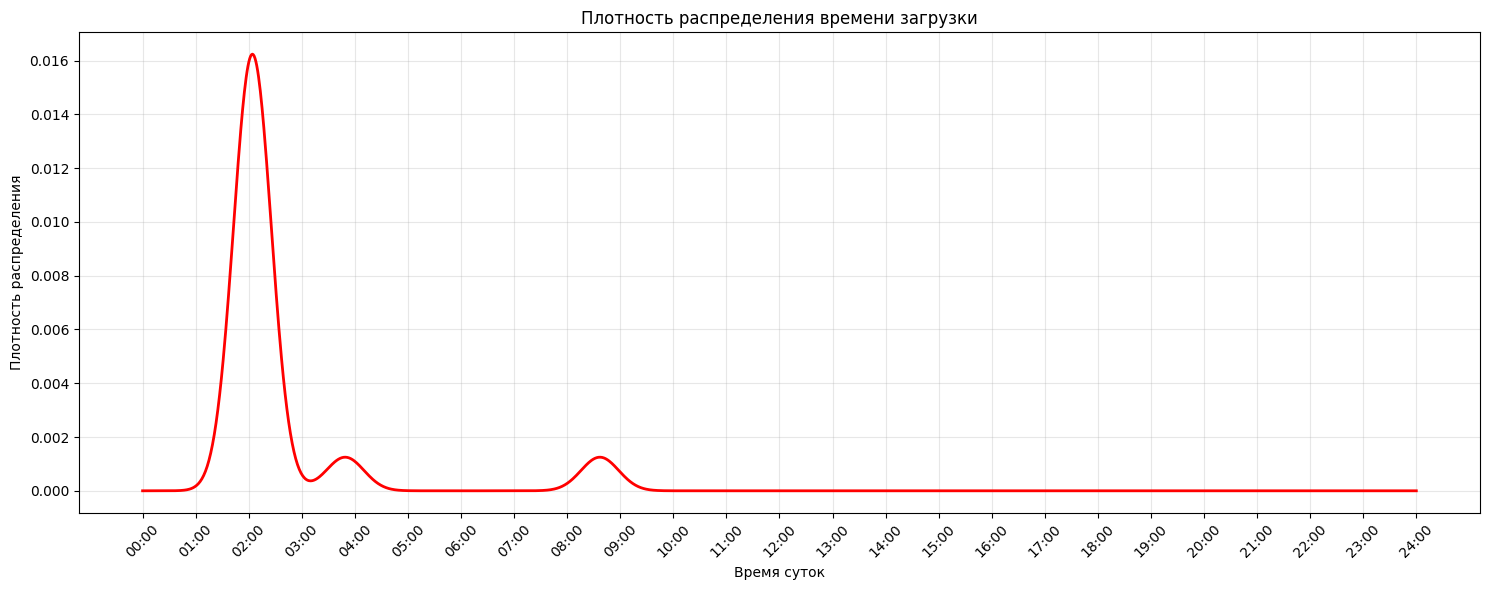

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter, HourLocator

# Загрузка данных (пример)
# df = pd.read_excel('your_file.xlsx')  # используйте ваш реальный источник данных

# Создаем тестовые данные, если нет реальных
data = {
    'snapshot_end_dttm': [
        '01.05.2024 2:04:28', '02.05.2024 2:03:49', '03.05.2024 2:04:08',
        '04.05.2024 2:04:40', '05.05.2024 2:04:16', '06.05.2024 2:05:41',
        '07.05.2024 2:06:15', '08.05.2024 2:05:28', '09.05.2024 8:37:20',
        '10.05.2024 2:03:34', '11.05.2024 2:04:55', '12.05.2024 3:49:17',
        '13.05.2024 2:04:36', '14.05.2024 2:04:00', '15.05.2024 2:04:40'
    ] * 150  # Умножаем для имитации 2000+ точек
}

df = pd.DataFrame(data)
df['snapshot_end_dttm'] = pd.to_datetime(df['snapshot_end_dttm'], format='%d.%m.%Y %H:%M:%S')

# Способ 1: Точечный график с преобразованием времени
plt.figure(figsize=(15, 6))

# Преобразуем время в минуты от начала суток
df['minutes'] = df['snapshot_end_dttm'].dt.hour * 60 + df['snapshot_end_dttm'].dt.minute

# Нормализуем для отображения на оси Y
y_values = np.ones(len(df)) * 0.5  # Все точки на одной высоте

plt.scatter(df['minutes'], y_values, alpha=0.1, s=10)
plt.xlim(0, 1440)  # 1440 минут = 24 часа
plt.ylim(0, 1)

# Настраиваем ось X
hours = range(0, 1441, 60)  # Каждый час
plt.xticks(hours, [f"{h//60:02d}:00" for h in hours], rotation=45)
plt.xlabel('Время суток')
plt.yticks([])
plt.title('Распределение времени загрузки (2000+ точек)')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Способ 2: Гистограмма (лучше для больших данных)
plt.figure(figsize=(15, 6))
plt.hist(df['minutes'], bins=48, range=(0, 1440), edgecolor='white')  # 48 интервалов по 30 минут
plt.xticks(hours, [f"{h//60:02d}:00" for h in hours], rotation=45)
plt.xlabel('Время суток')
plt.ylabel('Количество загрузок')
plt.title('Гистограмма распределения времени загрузки')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Способ 3: Плотность распределения (KDE)
plt.figure(figsize=(15, 6))

# Вычисляем плотность
from scipy.stats import gaussian_kde
density = gaussian_kde(df['minutes'])
x = np.linspace(0, 1440, 1440)
plt.plot(x, density(x), 'r-', linewidth=2)

# Настройки графика
plt.xticks(hours, [f"{h//60:02d}:00" for h in hours], rotation=45)
plt.xlabel('Время суток')
plt.ylabel('Плотность распределения')
plt.title('Плотность распределения времени загрузки')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
result_df.groupby(['database_nm','standart_time_load']).size().reset_index()#.sort_values('total_interval_count', ascending=False)

,database_nm,standart_time_load,0
0,data_bosskadrovik_dwh_etl,06:30:00,1
1,data_bosskadrovik_external,06:30:00,57
2,data_bosskadrovik_external,07:00:00,2
3,data_dparb_prod,02:30:00,2
4,data_estaff,06:30:00,9
5,data_surv,04:30:00,2
6,data_surv,05:00:00,3
7,data_surv,11:00:00,1
8,data_webtutor,06:30:00,9
9,data_webtutor,07:00:00,9


In [ ]:
# Разделение на словарь: ключ — имя схемы (database_nm), значение — DataFrame
dfs_by_schema = {
    schema: df for schema, df in result_df.groupby('database_nm')
}
print(dfs_by_schema)

In [ ]:
import plotly.express as px
import pandas as pd

# Разделение на схемы
dfs_by_schema = {
    schema: df for schema, df in result_df.groupby('database_nm')
}

# Интерактивные графики для каждой схемы
for schema, df_schema in dfs_by_schema.items():
    fig = px.bar(
        df_schema.sort_values('standart_time_interval_count', ascending=False),
        x='table_nm',
        y='standart_time_interval_count',
        color='standart_time_load',
        title=f'Стандартное время загрузки по таблицам (схема: {schema})',
        labels={
            'table_nm': 'Таблица',
            'standart_time_interval_count': 'Кол-во загрузок',
            'standart_time_load': 'Время'
        }
    )
    fig.update_layout(xaxis_tickangle=-45, height=500)
    fig.show()





In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Уникальные схемы
schemas = result_df['database_nm'].unique()

# Создание subplot с тремя графиками по 1 строке (одна схема — три метрики)
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Кол-во загрузок в стандартное время',
                                    'Среднее отклонение (мин)',
                                    'Процент отклонений'),
                    shared_yaxes=False)

buttons = []

# Добавляем трассы для каждой схемы
for i, schema in enumerate(schemas):
    df_schema = result_df[result_df['database_nm'] == schema]

    # График 1: Стандартное время загрузки
    fig.add_trace(
        go.Bar(
            x=df_schema['table_nm'],
            y=df_schema['standart_time_interval_count'],
            name=f'{schema} — Кол-во',
            visible=(i == 0),
            marker_color='steelblue',
            showlegend=False
        ),
        row=1, col=1
    )

    # График 2: Среднее отклонение
    fig.add_trace(
        go.Bar(
            x=df_schema['table_nm'],
            y=df_schema['avg_deviation_minutes'],
            name=f'{schema} — Отклонение',
            visible=(i == 0),
            marker_color='orange',
            showlegend=False
        ),
        row=1, col=2
    )

    # График 3: Процент отклонений
    fig.add_trace(
        go.Bar(
            x=df_schema['table_nm'],
            y=df_schema['percent_deviation'],
            name=f'{schema} — % отклонений',
            visible=(i == 0),
            marker_color='crimson',
            showlegend=False
        ),
        row=1, col=3
    )

    # Меню-кнопка: включает только текущую схему (3 графика подряд)
    visibility = [False] * (len(schemas) * 3)
    visibility[i * 3] = True       # график 1
    visibility[i * 3 + 1] = True   # график 2
    visibility[i * 3 + 2] = True   # график 3

    buttons.append(
        dict(
            label=schema,
            method='update',
            args=[{'visible': visibility},
                  {'title': f'Метрики загрузки по схеме: {schema}'}]
        )
    )

# Обновляем layout с выпадающим меню
fig.update_layout(
    title=f'Метрики загрузки по схеме: {schemas[0]}',
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 0.5,
        'xanchor': 'center',
        'y': 1.2,
        'yanchor': 'top'
    }],
    height=500,
    width=1200
)

fig.update_xaxes(tickangle=45)
fig.show()


# **Тесты**

In [ ]:
import re
import pandas as pd
import os
from typing import Dict, List
import time

def get_files():
    """
    Функция поиска файлов Excel для дальнейшей обработки.
    Возвращает словарь с названием excel файла и списком листов для обработки.
    """
    current_dir = os.getcwd() # Возвращает /content
    files = os.listdir(current_dir) # Возвращает список с файлами и папками расположенных в директории
    dict_files = {}

    # Листы для удаления
    excluded_sheets = {
                      'dwh_etl_min_max_avg',
                      'External_min_max_avg',
                      'data_dparb_prod',
                      'dm_estaff',
                      'data_surv',
                      'data_webtutor',
                      'data_webtutor_hdp'
                      }

    for file in files:
        if re.fullmatch(r'\w+\.xlsx', file):
            try:
                with pd.ExcelFile(os.path.join(current_dir, file)) as xls:
                    sheets = [sheet for sheet in xls.sheet_names if sheet not in excluded_sheets]
                    if sheets:  # Добавляем только если есть листы для обработки
                        dict_files[file] = sheets
            except Exception as e:
                print(f"Ошибка обработки файла {file}: {e}")

    return dict_files



def concat_dataframe() -> pd.DataFrame:
    """
    Объединяет данные из всех файлов и листов в один DataFrame.
    """
    dict_file_sheets = get_files()
    dfs = []

    for file_name, sheets in dict_file_sheets.items():
        print(f"Обрабатывается файл: {file_name}, листы: {sheets}")
        for sheet_name in sheets:
            try:
                df = pd.read_excel(
                    os.path.join(os.getcwd(), file_name),
                    sheet_name=sheet_name
                )
                dfs.append(df)
            except Exception as e:
                print(f"Ошибка чтения листа {sheet_name} файла {file_name}: {e}")

    if not dfs:
        raise ValueError("Нет файлов для обработки")

    df_all = pd.concat(dfs, ignore_index=True)
    print(f"Всего строк: {len(df_all)}")
    return df_all

In [ ]:
df = concat_dataframe()

Обрабатывается файл: boss_kadr_qrs_LAB.xlsx, листы: ['dwh_etl_full', 'external_full']
Обрабатывается файл: data_estaff.xlsx, листы: ['dm_estaff_det']
Обрабатывается файл: data_surv.xlsx, листы: ['data_surv_det']
Обрабатывается файл: data_webtutor_hdp.xlsx, листы: ['data_webtutor_hdp_det']
Обрабатывается файл: data_webtutor.xlsx, листы: ['data_webtutor_det']
Обрабатывается файл: data_dparb_prod.xlsx, листы: ['data_dparb_prod_det']
Всего строк: 34904


In [ ]:
df['snapshot_end_dttm'] = pd.to_datetime(
    df['snapshot_end_dttm'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce').dropna()

if df.empty:
    raise ValueError("Нет данных после преобразования даты/времени")

# Округление времени вверх до 30-й минуты и создание колонки только с временем
# Для дальнейшей группировки
df['hour_interval'] = df['snapshot_end_dttm'].dt.ceil('30min')
df['time_only'] = df['hour_interval'].dt.time

# Группировка и расчет количества интервалов
df_interval_count = (df[['database_nm', 'table_nm', 'time_only']]
                      .groupby(['database_nm', 'table_nm', 'time_only'])
                      .size()
                      .reset_index(name='interval_count')
                      )

# Поиск самых частых интервалов (стандартное время)
result = (df_interval_count
          .sort_values('interval_count', ascending=False)
          .drop_duplicates(subset=['database_nm', 'table_nm'])
          .reset_index(drop=True)
          )
result.head(5)

,database_nm,table_nm,time_only,interval_count
0,data_estaff,in_hadoop_parsed_messages,06:30:00,370
1,data_bosskadrovik_external,user_dwh_etl_vpr_ed_depts,06:30:00,366
2,data_bosskadrovik_external,user_dwh_etl_addr_live_hist,06:30:00,365
3,data_bosskadrovik_external,user_front_role_table,06:30:00,364
4,data_bosskadrovik_external,user_dwh_etl_pr_wk_his,06:30:00,364


In [ ]:
# Общее количество всех записей для каждой схема_таблица
total_counts_df = (df
                    .groupby(['database_nm', 'table_nm'])
                    .size()
                    .reset_index(name='total_count')
                    )
total_counts_df

,database_nm,table_nm,total_count
0,data_bosskadrovik_dwh_etl,user_vw_bp_struct_list,302
1,data_bosskadrovik_external,user_arhiv_tb_tabel,391
2,data_bosskadrovik_external,user_blok_structs,390
3,data_bosskadrovik_external,user_cells,96
4,data_bosskadrovik_external,user_dic_location_dwh_etl,23
...,...,...,...
114,data_webtutor_hdp,hr_edu_history_likes,100
115,data_webtutor_hdp,hr_edu_history_requests,103
116,data_webtutor_hdp,hr_edu_response,103
117,data_webtutor_hdp,hr_favourites_material,103


In [ ]:
# Расчет отклонения от стандартного времени
# ВПР основной таблицы, с таблицей где посчитано стандартное время
df_with_std_time = pd.merge(df,
                            result[['database_nm', 'table_nm', 'time_only']],
                            on=['database_nm', 'table_nm'],
                            suffixes=('', '_std')
                            )
df_with_std_time.head(2)

,database_nm,table_nm,extract_task_start_datetime,extract_task_end_datetime,apply_task_start_datetime,apply_task_end_datetime,snapshot_start_dttm,snapshot_end_dttm,load_time,load_time_to_sort,cron_time,hour_interval,time_only,time_only_std
0,data_bosskadrovik_dwh_etl,user_vw_bp_struct_list,2024-07-19 11:44:25.522,2024-07-19 11:44:25.522,2024-07-19 11:45:55.765,2024-07-19 11:47:10.792,2024-07-19 11:46:38.937,2024-07-19 11:47:02.940,0 years 0 mons 0 days 0 hours 1 mins 15.027268...,1.25,:,2024-07-19 12:00:00,12:00:00,06:30:00
1,data_bosskadrovik_dwh_etl,user_vw_bp_struct_list,2024-07-19 11:44:25.522,2024-07-19 11:44:25.522,2024-07-19 11:45:55.765,2024-07-19 11:47:10.792,2024-07-19 11:37:03.698,2024-07-19 11:39:29.518,0 years 0 mons 0 days 0 hours 1 mins 15.027268...,1.25,:,2024-07-19 12:00:00,12:00:00,06:30:00


In [ ]:
# Расчет время в минутах с полуночи
df_with_std_time['time_minutes'] = (df_with_std_time['snapshot_end_dttm'].dt.hour * 60
                                    +
                                    df_with_std_time['snapshot_end_dttm'].dt.minute
                                    )

df_with_std_time['std_time_minutes'] = (df_with_std_time['time_only_std']
                                        .apply(lambda x: x.hour * 60 + x.minute)
                                        )

# Время отклонения в минутах
df_with_std_time['deviation_minutes'] = (df_with_std_time['time_minutes']
                                          -
                                          df_with_std_time['std_time_minutes']
                                          )
df_with_std_time.head(2)

,database_nm,table_nm,extract_task_start_datetime,extract_task_end_datetime,apply_task_start_datetime,apply_task_end_datetime,snapshot_start_dttm,snapshot_end_dttm,load_time,load_time_to_sort,cron_time,hour_interval,time_only,time_only_std,time_minutes,std_time_minutes,deviation_minutes
0,data_bosskadrovik_dwh_etl,user_vw_bp_struct_list,2024-07-19 11:44:25.522,2024-07-19 11:44:25.522,2024-07-19 11:45:55.765,2024-07-19 11:47:10.792,2024-07-19 11:46:38.937,2024-07-19 11:47:02.940,0 years 0 mons 0 days 0 hours 1 mins 15.027268...,1.25,:,2024-07-19 12:00:00,12:00:00,06:30:00,707.0,390,317.0
1,data_bosskadrovik_dwh_etl,user_vw_bp_struct_list,2024-07-19 11:44:25.522,2024-07-19 11:44:25.522,2024-07-19 11:45:55.765,2024-07-19 11:47:10.792,2024-07-19 11:37:03.698,2024-07-19 11:39:29.518,0 years 0 mons 0 days 0 hours 1 mins 15.027268...,1.25,:,2024-07-19 12:00:00,12:00:00,06:30:00,699.0,390,309.0


In [ ]:
# Расчет среднего отклонение для схема_таблица
avg_deviation = (
    df_with_std_time.groupby(['database_nm', 'table_nm'])
    ['deviation_minutes']
    .mean()
    .round(2)
    .reset_index(name='avg_deviation_minutes')
)
avg_deviation

,database_nm,table_nm,avg_deviation_minutes
0,data_bosskadrovik_dwh_etl,user_vw_bp_struct_list,-0.63
1,data_bosskadrovik_external,user_arhiv_tb_tabel,-8.68
2,data_bosskadrovik_external,user_blok_structs,2.67
3,data_bosskadrovik_external,user_cells,32.32
4,data_bosskadrovik_external,user_dic_location_dwh_etl,135.48
...,...,...,...
113,data_webtutor_hdp,hr_edu_history_likes,-30.96
114,data_webtutor_hdp,hr_edu_history_requests,2.67
115,data_webtutor_hdp,hr_edu_response,9.21
116,data_webtutor_hdp,hr_favourites_material,6.41


In [ ]:
# ВПР всех результатов
final = pd.merge(
    result,
    total_counts_df,
    on=['database_nm', 'table_nm']
)

final = pd.merge(
    final,
    avg_deviation,
    on=['database_nm', 'table_nm']
)

# Расчет процента отклонений
final['percent_deviation'] = (((final['total_count'] - final['interval_count']) / final['total_count']) * 100).round(2)

final = final.rename(columns = {'time_only':'standart_time_load',
                    'interval_count':'standart_time_interval_count',
                    'total_count':'total_interval_count'})

In [ ]:
df_with_std_time#.query('deviation_minutes == 0').head(2)

,database_nm,table_nm,extract_task_start_datetime,extract_task_end_datetime,apply_task_start_datetime,apply_task_end_datetime,snapshot_start_dttm,snapshot_end_dttm,load_time,load_time_to_sort,cron_time,hour_interval,time_only,time_only_std,time_minutes,std_time_minutes,deviation_minutes
0,data_bosskadrovik_dwh_etl,user_vw_bp_struct_list,2024-07-19 11:44:25.522,2024-07-19 11:44:25.522,2024-07-19 11:45:55.765,2024-07-19 11:47:10.792,2024-07-19 11:46:38.937,2024-07-19 11:47:02.940,0 years 0 mons 0 days 0 hours 1 mins 15.027268...,1.25,:,2024-07-19 11:50:00,11:50:00,06:10:00,707.0,370,337.0
1,data_bosskadrovik_dwh_etl,user_vw_bp_struct_list,2024-07-19 11:44:25.522,2024-07-19 11:44:25.522,2024-07-19 11:45:55.765,2024-07-19 11:47:10.792,2024-07-19 11:37:03.698,2024-07-19 11:39:29.518,0 years 0 mons 0 days 0 hours 1 mins 15.027268...,1.25,:,2024-07-19 11:40:00,11:40:00,06:10:00,699.0,370,329.0
2,data_bosskadrovik_dwh_etl,user_vw_bp_struct_list,2024-07-22 10:35:56.726,2024-07-22 10:35:56.726,2024-07-22 10:36:44.390,2024-07-22 10:52:32.495,2024-07-22 10:49:03.267,2024-07-22 10:51:01.225,0 years 0 mons 0 days 0 hours 15 mins 48.10449...,15.80,:,2024-07-22 11:00:00,11:00:00,06:10:00,651.0,370,281.0
3,data_bosskadrovik_dwh_etl,user_vw_bp_struct_list,2024-07-23 06:04:06.296,2024-07-23 06:04:06.296,2024-07-23 06:08:08.192,2024-07-23 06:12:00.616,2024-07-23 06:09:22.968,2024-07-23 06:10:28.560,0 years 0 mons 0 days 0 hours 3 mins 52.423833...,3.87,:,2024-07-23 06:20:00,06:20:00,06:10:00,370.0,370,0.0
4,data_bosskadrovik_dwh_etl,user_vw_bp_struct_list,2024-07-24 06:03:20.815,2024-07-24 06:03:20.815,2024-07-24 06:07:47.501,2024-07-24 06:11:27.050,2024-07-24 06:08:40.815,2024-07-24 06:09:41.125,0 years 0 mons 0 days 0 hours 3 mins 39.54913 ...,3.66,:,2024-07-24 06:10:00,06:10:00,06:10:00,369.0,370,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34898,data_dparb_prod,ext_pf_staff_new,2024-11-14 02:03:57.854,2024-11-14 02:03:57.854,2024-11-14 02:05:02.698,2024-11-14 02:36:49.925,2024-11-14 02:29:36.346,2024-11-14 02:32:43.064,0 years 0 mons 0 days 0 hours 31 mins 47.22697...,31.79,:,2024-11-14 02:40:00,02:40:00,02:20:00,152.0,140,12.0
34899,data_dparb_prod,ext_pf_staff_new,2024-11-15 02:09:50.076,2024-11-15 02:09:50.076,2024-11-15 02:11:30.800,2024-11-15 02:41:07.069,2024-11-15 02:35:50.321,2024-11-15 02:37:19.227,0 years 0 mons 0 days 0 hours 29 mins 36.26888...,29.60,:,2024-11-15 02:40:00,02:40:00,02:20:00,157.0,140,17.0
34900,data_dparb_prod,ext_pf_staff_new,2024-11-16 02:27:24.472,2024-11-16 02:27:24.472,2024-11-16 02:29:49.007,2024-11-16 02:37:44.246,2024-11-16 02:34:36.967,2024-11-16 02:36:24.837,0 years 0 mons 0 days 0 hours 7 mins 55.239073...,7.92,:,2024-11-16 02:40:00,02:40:00,02:20:00,156.0,140,16.0
34901,data_dparb_prod,ext_pf_staff_new,2024-11-17 03:30:25.324,2024-11-17 03:30:25.324,2024-11-21 13:39:57.269,2024-11-21 13:43:48.648,NaT,NaT,0 years 0 mons 0 days 0 hours 3 mins 51.379426...,3.86,:,NaT,NaT,02:20:00,NaN,140,NaN


# **Функция**

написать функцию которая конкатит все эксель файлы и листы в один дата фрейм

После чего обрабатывать одну большую таблицу

создать в хадупе таблицу и грузить в нее результат

дропать лишние колонки пред конкатом, позволит избежать ошибок не совпадения столбцов и быстрее работать удет

In [ ]:
df['snapshot_end_dttm'] = pd.to_datetime(df['snapshot_end_dttm'], format='%Y-%m-%d %H:%M:%S')
df['hour_interval'] = df['snapshot_end_dttm'].dt.ceil('10min') #ceil округление вверх; round округление до ближайшего
df['time_only'] = df['hour_interval'].dt.time
new_df = df[['database_nm', 'table_nm', 'snapshot_end_dttm', 'hour_interval', 'time_only']]
df_interval_count = new_df.groupby(['database_nm', 'table_nm', 'time_only']).size().reset_index(name = 'interval_count')
result = (df_interval_count.sort_values('interval_count', ascending = False)).drop_duplicates(subset=['database_nm', 'table_nm']).reset_index(drop=True)
total_counts_df = new_df.groupby(['database_nm', 'table_nm']).size().reset_index(name = 'total_count')
final = pd.merge(result, total_counts_df, on = ['database_nm', 'table_nm'])
final['percent_otkloneniy'] = (((final['total_count'] - final['interval_count']) / final['total_count']) * 100).round(2)

In [ ]:
final

,database_nm,table_nm,time_only,interval_count,total_count,percent_otkloneniy
0,data_bosskadrovik_external,user_hrtb_okin_relativ,06:20:00,302,390,22.56
1,data_bosskadrovik_external,user_dwh_etl_typ_ill,06:20:00,301,390,22.82
2,data_bosskadrovik_external,user_dwh_etl_vpr_ed_depts,06:10:00,296,390,24.10
3,data_bosskadrovik_external,user_dwh_etl_card,06:20:00,293,390,24.87
4,data_bosskadrovik_external,user_dwh_etl_pr_leave_add,06:20:00,290,390,25.64
...,...,...,...,...,...,...
113,data_estaff,in_hadoop_model_rep,06:10:00,8,13,38.46
114,data_bosskadrovik_external,user_hrtb_address_dic_location_dwh_etl,06:40:00,5,23,78.26
115,data_surv,dadm_program_agg_hist_buffer,10:40:00,2,7,71.43
116,data_webtutor,hadoop_hr_adapt_task,14:10:00,1,3,66.67


In [ ]:
df['snapshot_end_dttm'] = pd.to_datetime(df['snapshot_end_dttm'], format='%Y-%m-%d %H:%M:%S')
df['hour_interval'] = df['snapshot_end_dttm'].dt.ceil('10min') #ceil округление вверх; round округление до ближайшего
df['time_only'] = df['hour_interval'].dt.time
new_df = df[['database_nm', 'table_nm', 'snapshot_end_dttm', 'hour_interval', 'time_only']]
df_interval_count = new_df.groupby(['database_nm', 'table_nm', 'time_only']).size().reset_index(name = 'interval_count')
result = (df_interval_count.sort_values('interval_count', ascending = False)).drop_duplicates(subset=['database_nm', 'table_nm']).reset_index(drop=True)
total_counts_df = new_df.groupby(['database_nm', 'table_nm']).size().reset_index(name = 'total_count')
final = pd.merge(result, total_counts_df, on = ['database_nm', 'table_nm'])
final['percent_otkloneniy'] = ((final['total_count'] - final['interval_count'] / final['total_count']) * 100).round(2)
#Поиск максимума -> получаем индекс
#popular_interval = new_df['time_only'].value_counts().idxmax()
#standart_time_load = new_df[new_df['time_only'] == popular_interval]['time_only'].max()
#print(f'Стандартное время загрузки {standart_time_load}')

#lower_b = (pd.to_datetime(str(standart_time_load)) - pd.Timedelta(minutes=30)).time()
#upper_b = (pd.to_datetime(str(standart_time_load)) + pd.Timedelta(minutes=30)).time()

#t = len(new_df)
#in_interval = new_df['time_only'].between(lower_b, upper_b).sum()
#out_interval = t - in_interval

#percent = (out_interval/t)*100
#print(percent)

In [ ]:
final

,database_nm,table_nm,time_only,interval_count,total_count,percent_otkloneniy
0,data_dparb_prod,ext_motiv_results,02:10:00,180,396,39554.55
1,data_dparb_prod,ext_pf_staff_new,02:20:00,61,201,20069.65


In [ ]:
test_df = new_df.groupby(['database_nm', 'table_nm']).size().reset_index(name = 'total_count')
test_df.head(10)

,database_nm,table_nm,total_count
0,data_dparb_prod,ext_motiv_results,396
1,data_dparb_prod,ext_pf_staff_new,201


In [ ]:
result = (test_df.sort_values('interval_count', ascending = False)).drop_duplicates(subset=['database_nm', 'table_nm']).reset_index(drop=True)
result

KeyError: 'interval_count'

In [ ]:
test_df.groupby(['database_nm', 'table_nm']).agg({'hour_interval' : 'max'}).reset_index()

KeyError: "Column(s) ['hour_interval'] do not exist"

In [ ]:
test_df.to_excel('test.xlsx')

In [ ]:
df = pd.read_excel(boss_kadr_qrs_lab_file_path, sheet_name = 'dwh_etl_full')
boss_kadr_qrs_lab_df.head(2)

In [ ]:
test_df = new_df.groupby(['database_nm', 'table_nm', 'time_only']).value_counts('time_only')
test_df

database_nm        table_nm              time_only  snapshot_end_dttm        hour_interval      
data_webtutor_hdp  hadoop_hr_adapt_task  07:10:00   2024-08-09 07:07:09.425  2024-08-09 07:10:00    1
                                         07:20:00   2024-08-19 07:12:29.893  2024-08-19 07:20:00    1
                                                    2024-08-29 07:13:36.766  2024-08-29 07:20:00    1
                                                    2024-08-28 07:10:00.354  2024-08-28 07:20:00    1
                                                    2024-08-27 07:11:12.339  2024-08-27 07:20:00    1
                                                                                                   ..
                   hr_video_view         07:10:00   2025-02-18 07:05:48.458  2025-02-18 07:10:00    1
                                         09:00:00   2025-03-18 08:54:18.674  2025-03-18 09:00:00    1
                                         10:00:00   2025-02-28 09:57:57.255  2025-02-28

# Расчеты

In [ ]:
import pandas as pd

In [ ]:
# Проверка пути
import os
os.getcwd()

'/work/OPALAB_15056'

In [ ]:
# Путь к excel файлу
boss_kadr_qrs_lab_file_path = '/work/OPALAB_15056/boss_kadr_qrs_LAB.xlsx'
boss_kadr_qrs_lab = pd.ExcelFile(boss_kadr_qrs_lab_file_path)
boss_kadr_qrs_lab

In [ ]:
sheet_names = boss_kadr_qrs_lab.sheet_names
print(f'В файле boss_kadr_qrs_LAB.xlsx - листы {sheet_names}')

В файле boss_kadr_qrs_LAB.xlsx - листы ['dwh_etl_min_max_avg', 'dwh_etl_full', 'External_min_max_avg', 'external_full']


In [ ]:
boss_kadr_qrs_lab_df = pd.read_excel(boss_kadr_qrs_lab_file_path, sheet_name = ['dwh_etl_full','external_full'])
boss_kadr_qrs_lab_df

In [ ]:
boss_kadr_qrs_lab_df.columns

Index(['database_nm', 'table_nm', 'extract_task_start_datetime',
       'extract_task_end_datetime', 'apply_task_start_datetime',
       'apply_task_end_datetime', 'snapshot_start_dttm', 'snapshot_end_dttm',
       'load_time', 'load_time_to_sort', 'cron_time'],
      dtype='object')

In [ ]:
boss_kadr_qrs_lab_df['snapshot_end_dttm'] = pd.to_datetime(boss_kadr_qrs_lab_df['snapshot_end_dttm'], format='%Y-%m-%d %H:%M:%S')
boss_kadr_qrs_lab_df['snapshot_end_dttm']

0     2024-07-19 11:47:02.940
1     2024-07-19 11:39:29.518
2     2024-07-22 10:51:01.225
3     2024-07-23 06:10:28.560
4     2024-07-24 06:09:41.125
                ...          
297   2025-05-18 06:04:09.654
298   2025-05-19 06:04:28.837
299   2025-05-20 06:04:04.839
300   2025-05-21 06:07:54.833
301   2025-05-22 06:04:48.298
Name: snapshot_end_dttm, Length: 302, dtype: datetime64[ns]

In [ ]:
boss_kadr_qrs_lab_df['hour_interval'] = boss_kadr_qrs_lab_df['snapshot_end_dttm'].dt.ceil('10min') #ceil округление вверх; round округление до ближайшего
boss_kadr_qrs_lab_df['time_only'] = boss_kadr_qrs_lab_df['hour_interval'].dt.time

boss_kadr_qrs_lab_df[['snapshot_end_dttm', 'hour_interval', 'time_only']]

,snapshot_end_dttm,hour_interval,time_only
0,2024-07-19 11:47:02.940,2024-07-19 11:50:00,11:50:00
1,2024-07-19 11:39:29.518,2024-07-19 11:40:00,11:40:00
2,2024-07-22 10:51:01.225,2024-07-22 11:00:00,11:00:00
3,2024-07-23 06:10:28.560,2024-07-23 06:20:00,06:20:00
4,2024-07-24 06:09:41.125,2024-07-24 06:10:00,06:10:00
...,...,...,...
297,2025-05-18 06:04:09.654,2025-05-18 06:10:00,06:10:00
298,2025-05-19 06:04:28.837,2025-05-19 06:10:00,06:10:00
299,2025-05-20 06:04:04.839,2025-05-20 06:10:00,06:10:00
300,2025-05-21 06:07:54.833,2025-05-21 06:10:00,06:10:00


In [ ]:
#Поиск максимума -> получаем индекс
popular_interval = boss_kadr_qrs_lab_df['time_only'].value_counts().idxmax()

In [ ]:
x = boss_kadr_qrs_lab_df[boss_kadr_qrs_lab_df['time_only'] == popular_interval]['time_only'].max()
print(f'Стандартное время загрузки {x}')

Стандартное время загрузки 06:10:00


In [ ]:
lower_b = (pd.to_datetime(str(x)) - pd.Timedelta(minutes=30)).time()
upper_b = (pd.to_datetime(str(x)) + pd.Timedelta(minutes=30)).time()

t = len(boss_kadr_qrs_lab_df)
in_interval = boss_kadr_qrs_lab_df['time_only'].between(lower_b, upper_b).sum()
out_interval = t - in_interval

In [ ]:
percent = (out_interval/t)*100
percent

7.9470198675496695

In [ ]:
df = boss_kadr_qrs_lab_df.groupby('time_only').agg({'hour_interval' : 'count'}).reset_index()
df

,time_only,hour_interval
0,06:10:00,224
1,06:20:00,46
2,06:30:00,6
3,06:40:00,2
4,06:50:00,2
5,07:00:00,1
6,07:20:00,2
7,07:30:00,2
8,07:50:00,1
9,08:00:00,1


In [ ]:
df['time_only'] = pd.to_datetime(df['time_only'], format='%H:%M:%S').dt.time

In [ ]:
def time_to_sec(t):
    return t.hour * 3600 + t.minute * 60 + t.second

df['time_sec'] = df['time_only'].apply(time_to_sec)

In [ ]:
df.dtypes

time_only        object
hour_interval     int64
time_sec          int64
dtype: object

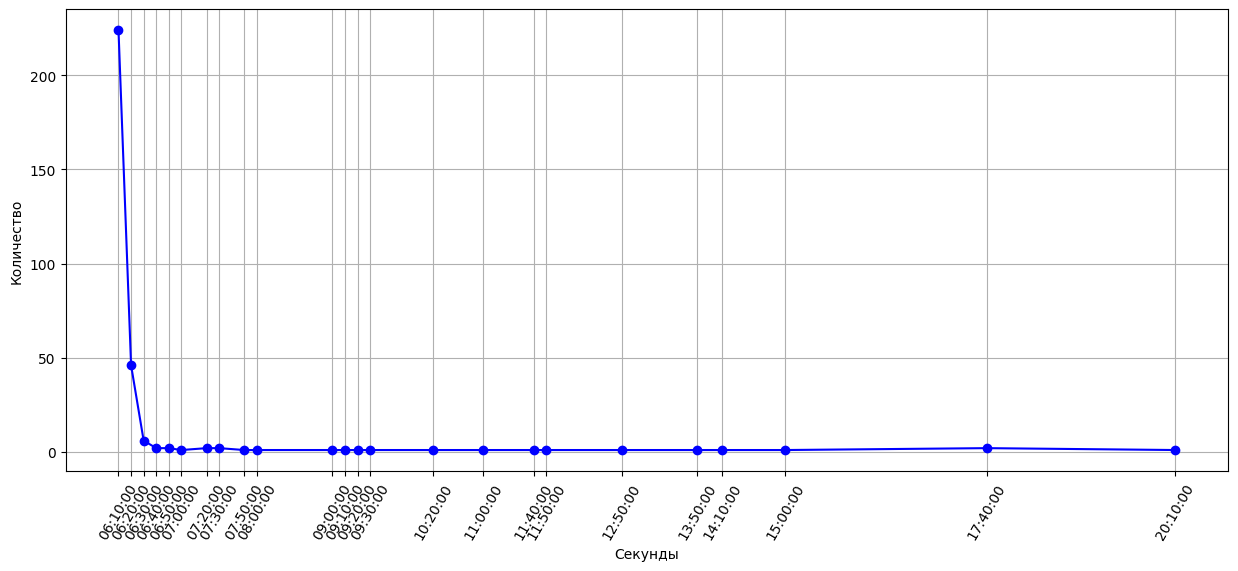

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,6))
plt.plot(df["time_sec"], df["hour_interval"], marker = "o", color = "blue")
plt.xlabel('Секунды')
plt.ylabel('Количество')
plt.grid(True)

plt.xticks(ticks = df["time_sec"], labels = df["time_only"].astype(str), rotation = 60)
plt.show()

In [ ]:
df = pd.DataFrame()
df['time'] = boss_kadr_qrs_lab_df['snapshot_end_dttm'].dt.time
df['hour'] = boss_kadr_qrs_lab_df['snapshot_end_dttm'].dt.hour
df['hour']

0      11
1      11
2      10
3       6
4       6
       ..
297     6
298     6
299     6
300     6
301     6
Name: hour, Length: 302, dtype: int64

In [ ]:
import matplotlib.pyplot as plt

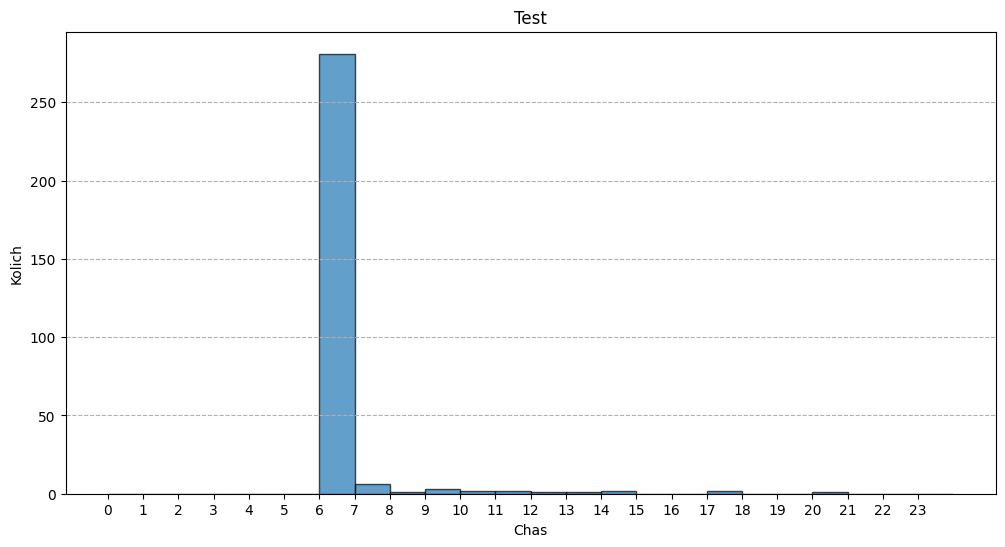

In [ ]:
plt.figure(figsize = (12,6))
plt.hist(df['hour'], bins = 24, range=(0, 24), edgecolor = 'black', alpha = 0.7)
plt.xlabel('Chas')
plt.ylabel('Kolich')
plt.xticks(range(0, 24))
plt.title('Test')
plt.grid(axis = 'y', linestyle = '--')
plt.show()

In [ ]:
boss_kadr_qrs_lab_df[['snapshot_end_dttm']].describe()

In [ ]:
!tar cvfz all_files.tar.gz --exclude=share --exclude=venvs *

README.txt
Untitled.ipynb
all.xlsx
boss_kadr_qrs_LAB.xlsx
data_dparb_prod.xlsx
data_estaff.xlsx
data_surv.xlsx
data_webtutor.xlsx
data_webtutor_hdp.xlsx
